# Short description
This will be a notebook that loads the data, creates the volatility forecast, then trains the model to predict the changes in volatility ranknings.

The starting point is har_checkpoint7, with the following changes:
1. I want to move the training functionality to a py file
2. If any of the data loading functionality can be optimized so i can reuse it in the code that will run the simulation, I want to do that and move it to the py file.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
#project_root = os.path.abspath(os.path.join(os.getcwd(), ".."))
#sys.path.insert(0, project_root)
sys.path.append("..") 
sys.path.append("../src")
from src.load_data import  prepare_volatility_data
from src.forecast import build_forecast_pipeline
from src.signals import generate_signals_and_positions
from src.analytic_utils import align_multiple
from src.model_train import split_train_test_multiple_with_validation
from src.classifier import create_classifier_features, format_model_inputs
from src.checkpoint_storage import save_all_checkpoints, load_all_checkpoints
from src.training import train_model_with_validation
from src.evaluation import plot_model_diagnostics

import pandas as pd



checkpoint=load_all_checkpoints("../checkpoints/har_checkpoint8_20250728_155801")

In [4]:
import json
import yaml

with open("../configs/config.json") as f:
    config_data = json.load(f)

with open("../configs/config.yaml") as f:
    config_exp = yaml.safe_load(f)

print(config_data)
print(config_exp)

{'realized_path': 'data/iv_data.parquet', 'implied_path': 'data/iv_implied.parquet', 'price_path': 'data/underlying_prices.parquet', 'forecast_horizon': 5, 'model_path': 'models/best_model.pkl', 'new_realized_path': 'data/new_realized.parquet', 'new_implied_path': 'data/new_implied.parquet', 'option_chain_path': 'data/option_chain.parquet', 'output_ledger_path': 'results/ledger.parquet', 'train_test_split_ratio': 0.7, 'train_test_gap_days': 21, 'ranking_threshold': 0.9, 'signal_z': True, 'implied_z': True, 'rf_params': {'n_estimators': 100, 'max_depth': 5}, 'har_windows': {'short': 1, 'medium': 5, 'long': 21}}
{'experiment_name': 'v2_rf_20pct', 'signal_threshold': 0.2, 'features': ['signal', 'signal_rank', 'implied', 'implied_rank'], 'model': {'type': 'random_forest', 'hyperparams': {'n_estimators': 100, 'max_depth': 5}}}


# Load the data


In [5]:
vol_data = prepare_volatility_data(config_data)

/Users/stirlitz/ncGitHub/vol_forecast/notebooks/../src/load_data.py:132: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  df_returns = df_prices.pct_change()


In [6]:
forecast = build_forecast_pipeline(vol_data["realized"], vol_data["earnings_mask"], config_data)

In [7]:
signals, positions = generate_signals_and_positions(forecast, vol_data["implied"]) #signal is just forecast - implied, positions is not really used
aligned_realized, aligned_implied, aligned_forecast, aligned_signal, aligned_positions = align_multiple(
    vol_data['future_realized'], vol_data['implied'], forecast, signals, positions, align_columns=True
)
aligned_vol_indeces=None

In [8]:
# STEP 1: Replace your train/test split:
train_dfs, val_dfs, test_dfs = split_train_test_multiple_with_validation(
    aligned_realized,
    aligned_implied,
    aligned_forecast,
    aligned_signal,
    aligned_positions,
    aligned_vol_indeces,  # Add this
    train_ratio=config_data["train_test_split_ratio"],
    train_test_gap_days=config_data["train_test_gap_days"]
)

# Unpack all splits
(train_realized, train_implied, train_forecast, train_signal, train_positions, train_vol_indeces) = train_dfs
(val_realized, val_implied, val_forecast, val_signal, val_positions, val_vol_indeces) = val_dfs  
(test_realized, test_implied, test_forecast, test_signal, test_positions, test_vol_indeces) = test_dfs

Train: 2022-02-02 00:00:00 to 2023-06-05 00:00:00 (336 days)
Val: 2023-07-07 00:00:00 to 2023-10-19 00:00:00 (74 days)
Test: 2023-11-20 00:00:00 to 2023-12-29 00:00:00 (28 days)


In [9]:
from dataclasses import dataclass, field
from typing import Dict, Optional
import pandas as pd

@dataclass
class ExperimentDataset:
    realized: pd.DataFrame
    implied: pd.DataFrame
    forecast: pd.DataFrame
    signal: pd.DataFrame
    positions: Optional[pd.DataFrame] = None
    vol_indeces: Optional[pd.DataFrame] = None
    features: Dict[str, pd.DataFrame] = field(default_factory=dict)
    label_matrix: Optional[pd.DataFrame] = None
    X_df: Optional[pd.DataFrame] = None
    y_series: Optional[pd.Series] = None
    idx: Optional[pd.Index] = None

In [11]:
def enrich_dataset(raw_data, config, threshold) -> ExperimentDataset:
    features, label_matrix = create_classifier_features(
        config,
        raw_data["realized"],
        raw_data["implied"],
        raw_data["forecast"],
        raw_data["signal"]
    )

    config_features_keys = config["features"]
    config_features= {k: features[k] for k in config_features_keys if k in features}
    #config_features=features[config_features_keys]
    X_df, y_series, idx = format_model_inputs(label_matrix, config_features, threshold=threshold)

    return ExperimentDataset(
        realized=raw_data["realized"],
        implied=raw_data["implied"],
        forecast=raw_data["forecast"],
        signal=raw_data["signal"],
        positions=raw_data.get("positions"),
        vol_indeces=raw_data.get("vol_indeces"),
        features=features,
        label_matrix=label_matrix,
        X_df=X_df,
        y_series=y_series,
        idx=idx
    )

In [14]:
dataset_names = ["train", "val", "test"]
dataset_keys = ["realized", "implied", "forecast", "signal", "positions", "vol_indeces"]
splits = {"train": train_dfs, "val": val_dfs, "test": test_dfs}
data_set_dicts: Dict[str, ExperimentDataset] = {}

In [16]:
def extract_raw_split(name: str, splits: dict[str, list[pd.DataFrame]], keys: list[str]) -> dict[str, pd.DataFrame]:
    """
    Given a split name ('train', 'val', 'test'), returns a dict:
    {
        'realized': df,
        'implied': df,
        ...
    }
    """
    return dict(zip(keys, splits[name]))

for split_name in ["train", "val", "test"]:
    raw_data = extract_raw_split(split_name,splits, dataset_keys)
    dataset = enrich_dataset(raw_data, config_exp, threshold=0.2)
    data_set_dicts[split_name] = dataset

for name, ds in data_set_dicts.items():
    print(f"{name} shapes:")
    print(ds.X_df.shape, ds.y_series.shape, ds.idx.shape)

train shapes:
(128977, 4) (128977,) (128977,)
val shapes:
(25973, 4) (25973,) (25973,)
test shapes:
(11020, 4) (11020,) (11020,)


In [119]:
save_all_checkpoints(
    output_root="../checkpoints",
    experiment_name="har_checkpoint8",
    X_df=data_set_dicts["train"].X_df,
    y=data_set_dicts["train"].y_series,
    label_matrix=data_set_dicts["train"].label_matrix,
    model=None,
    metrics=None,
    config=config_data,
    idx=data_set_dicts["train"].idx,
    features=data_set_dicts["train"].features,
    extras=None
)

📦 Saving experiment outputs to: ../checkpoints/har_checkpoint8_20250731_141753
Saving X_df to ../checkpoints/har_checkpoint8_20250731_141753/X_df.parquet
X_df saved to ../checkpoints/har_checkpoint8_20250731_141753/X_df.parquet


/Users/stirlitz/miniconda3/envs/ml_env13/lib/python3.13/site-packages/pandas/io/parquet.py:190: UserWarning: The DataFrame has column names of mixed type. They will be converted to strings and not roundtrip correctly.
  table = self.api.Table.from_pandas(df, **from_pandas_kwargs)


'../checkpoints/har_checkpoint8_20250731_141753'

In [111]:
checkpoint=load_all_checkpoints("../checkpoints/har_checkpoint8_20250728_173403")

In [ ]:
config_exp["features"]

['signal', 'signal_rank', 'implied', 'implied_rank']

In [25]:
X_train=data_set_dicts["train"].X_df
y_train=data_set_dicts["train"].y_series
X_val=data_set_dicts["val"].X_df
y_val=data_set_dicts["val"].y_series
X_test=data_set_dicts["test"].X_df
y_test=data_set_dicts["test"].y_series

# STEP 3: Train model properly:
best_model = train_model_with_validation(X_train, y_train, X_val, y_val)

Best validation AUC: 0.7662
Best params: {'max_depth': 3, 'n_estimators': 100, 'min_samples_split': 2}


Test AUC score: 0.7483

Feature Importance:
implied_rank    0.651169
implied         0.315859
signal_rank     0.030973
signal          0.001999
dtype: float64
✓ All improvements implemented successfully!


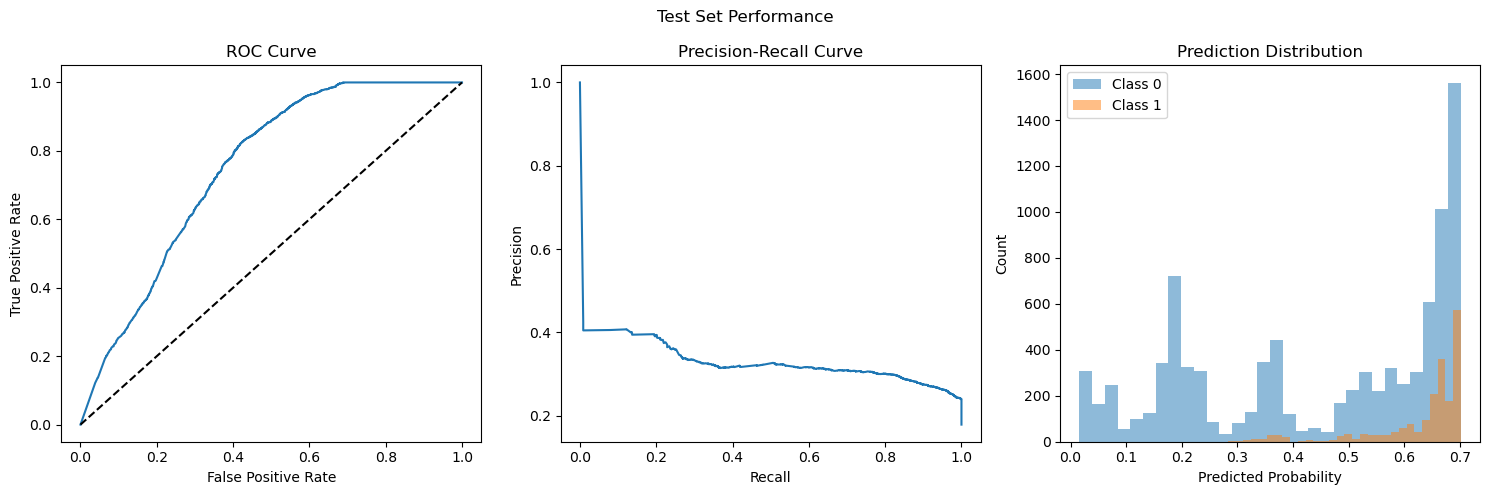

In [28]:
# STEP 4: Evaluate on test set:
test_pred_proba = best_model.predict_proba(X_test)[:, 1]
test_pred = best_model.predict(X_test)
#calculate area under curve
from sklearn.metrics import roc_auc_score
auc_score = roc_auc_score(y_test, test_pred_proba)
print(f"Test AUC score: {auc_score:.4f}")

# STEP 5: Get business metrics and diagnostics:
plot_model_diagnostics(y_test, test_pred_proba, "Test Set Performance")

# Feature importance
feature_importance = pd.Series(
    best_model.feature_importances_, 
    index=X_train.columns
).sort_values(ascending=False)
print("\nFeature Importance:")
print(feature_importance)

# STEP 6: Calculate strategy performance (if you have returns data):
# Assuming you have a returns matrix aligned with your realized vol
# strategy_metrics = calculate_strategy_performance(test_positions, test_returns)
# print(f"\nStrategy Performance: {strategy_metrics}")

print("✓ All improvements implemented successfully!")

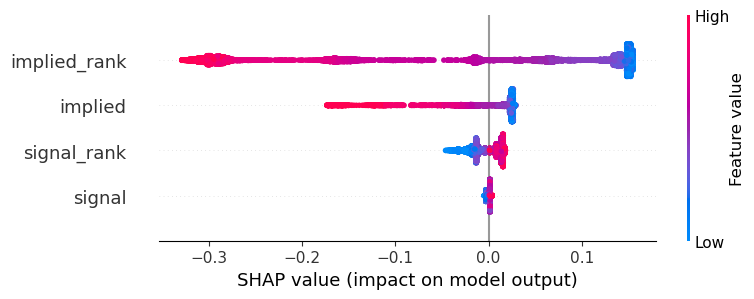

In [19]:
import  shap

explainer = shap.Explainer(best_model, X_test)
shap_values = explainer(X_test)

shap.summary_plot(shap_values[..., 1], X_test)

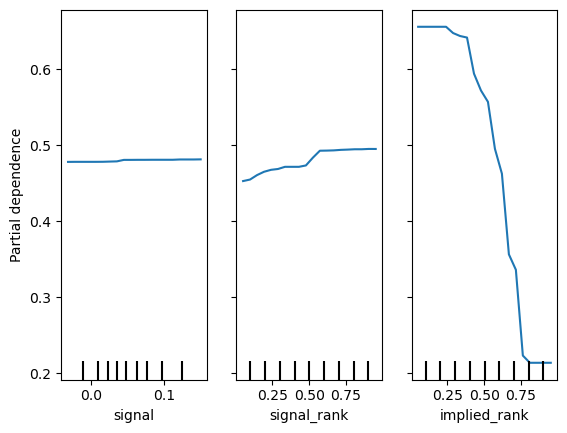

In [29]:
from sklearn.inspection import PartialDependenceDisplay

PartialDependenceDisplay.from_estimator(best_model, X_test, features=[0,1,3], grid_resolution=20)

In [30]:
from sklearn.metrics import roc_auc_score
def evaluate_feature_contributions(X, y, model, base_auc):

    dropped_scores = {}
    for col in X.columns:
        auc_drop = roc_auc_score(y, model.fit(X.drop(columns=[col]), y).predict_proba(X.drop(columns=[col]))[:,1])
        dropped_scores[col] = base_auc - auc_drop
    return dropped_scores


all_score=roc_auc_score(y_val, best_model.fit(X_val,y_val).predict_proba(X_val)[:,1])
evaluate_feature_contributions(X_val, y_val, best_model, all_score)

{'signal': np.float64(0.0008952309317710183),
 'signal_rank': np.float64(0.002789065049942585),
 'implied': np.float64(0.007320319793068353),
 'implied_rank': np.float64(0.022208356439326504)}